In [35]:
!pip install opencv-python pandas numpy matplotlib seaborn


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


### Init

In [36]:
import os, sys
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

BASE_PATH = os.getcwd()
DATA_PATH = os.path.join(BASE_PATH, 'data')
IMG_PATH = os.path.join(DATA_PATH, 'simsim')

### Definitions

In [37]:
probe_length = 0.02028  # The length of the probe in meters
probe_width = 0.002  # The width of the probe in meters
probe_offset_x = 0.00221
probe_offset_y = 0

focal_length = 0.00275  # The focal length of the camera in m
sensor_width = 0.00645  # The width of the camera sensor in m
sensor_height = 0.00363  # The height of the camera sensor in m

probe_base_center = (0, 1241)
probe_base_radius = 225
probe_base_left = (probe_base_center[0] - probe_base_radius, probe_base_center[1])


probe_tip_center = (1110, 1235)
probe_tip_radius = 70
probe_tip_left = (probe_tip_center[0] - probe_tip_radius, probe_tip_center[1])

min_probe_length = 0.005169

In [38]:

def load_images(path = IMG_PATH):
    """
    Load all images from the specified directory.

    Parameters:
    path (str): The path to the directory containing images. Defaults to IMG_PATH.

    Returns:
    list: A list of tuples, where each tuple contains the filename and the image array.
    """""""""
    images_df = pd.DataFrame({
        'filename': list(os.listdir(path)),
    })
    images_df['img'] = images_df['filename'].apply(lambda x: cv2.imread(os.path.join(path, x)))
    images_df['real_radius'] = images_df['filename'].apply(lambda x: float(x.split('_')[1].split('mm')[0])/2)
    return images_df

# using cv2 find a gray circle the middle of the image

def find_circle(image):
    """
    Find a circle in the middle of the image.

    Parameters:
    image (np.array): The image to search for a circle.

    Returns:
    tuple: A tuple containing the x, y coordinates and the radius of the circle.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = cv2.medianBlur(gray, 5)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=0, maxRadius=0)
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            return (i[0], i[1], i[2])
    return None


# paint the circle on the image
def draw_circle(image, circle, size=20, width=5, color=(0, 0, 255)):
    """
    Draw a circle on the image.

    Parameters:
    image (np.array): The image to draw the circle on.
    circle (tuple): A tuple containing the x, y coordinates and the radius of the circle.

    Returns:
    np.array: The image with the circle drawn on it.
    """
    if circle is not None:
        cv2.circle(image, (circle[0], circle[1]), circle[2], (0, 255, 0), 1)
        # draw the center of the circle as cross
        cv2.line(image, (circle[0] -size, circle[1]), (circle[0] +size, circle[1]), (0, 255, 0), width)
        cv2.line(image, (circle[0], circle[1] -size), (circle[0], circle[1] +size), (0, 255, 0), width)
        
    return image


def draw_center(image, size=20, width=5, color=(0, 0, 255)):
    """
    Draw the center of the image on the image.

    Parameters:
    image (np.array): The image to draw the center on.

    Returns:
    np.array: The image with the center drawn on it.
    """
    img_center = (image.shape[1] // 2, image.shape[0] // 2)
    cv2.line(image, (img_center[0] - size, img_center[1]), (img_center[0] + size, img_center[1]), color, width)
    cv2.line(image, (img_center[0], img_center[1] - size), (img_center[0], img_center[1] + size), color, width)
    return image

def plt_img(image, title=None):
    scale2x = cv2.resize(image, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()
    
    
def line_circle_intersection(p, v, c, r):
    """
    Finds intersection points between a line and a circle.
    
    Parameters:
        p (tuple): A point on the line (px, py).
        v (tuple): Direction vector of the line (vx, vy).
        c (tuple): Center of the circle (cx, cy).
        r (float): Radius of the circle.
    
    Returns:
        list: A list of intersection points [(x1, y1), (x2, y2)] or [] if no intersection.
    """
    px, py = p
    vx, vy = v
    cx, cy = c
    px, py, cx, cy, vx, vy, r = map(np.float128, [px, py, cx, cy, vx, vy, r])


    # Quadratic coefficients
    A = vx**2 + vy**2
    B = 2 * (vx * (px - cx) + vy * (py - cy))
    C = (px - cx)**2 + (py - cy)**2 - r**2

    # Compute discriminant
    discriminant = B**2 - 4*A*C

    # No intersection
    if discriminant < 0:
        return []

    # Compute the two possible values of t
    sqrt_disc = np.sqrt(discriminant)
    t1 = (-B + sqrt_disc) / (2*A)
    t2 = (-B - sqrt_disc) / (2*A)

    # Compute intersection points
    p1 = (int(px + t1 * vx), int(py + t1 * vy))
    p2 = (int(px + t2 * vx), int(py + t2 * vy))

    return [p1, p2] if discriminant > 0 else [p1]  # One or two intersections


def draw_probe(image, size=70, width=2, color=(0, 200, 200)):
    """
    Draw the center of the image on the image.

    Parameters:
    image (np.array): The image to draw the center on.

    Returns:
    np.array: The image with the center drawn on it.
    """
    # draw the probe base
    cv2.line(image, probe_base_center, probe_tip_center, color, width)

    # cv2.ellipse(image, probe_base_center, (int(probe_base_radius*(1)), probe_base_radius), 0, 0, 360, color, width*5)
    def _():
        for i in range(15):
            mult = i * 0.1
            center = (int(probe_tip_center[0] * mult), probe_tip_center[1])
            radius = int(probe_center_x_to_tip_radius(center[0]))
            # print(f"center: {center}, width: {width}, height: {height}")
            cv2.ellipse(image, center, (abs(radius), abs(radius)), 0, 0, 360, color, 1)
    # _()
    
    # cv2.line(image, probe_tip_left, (circle_left - delta_y), (200,20,150), width*2)

    # draw cross for the probe tip
    cv2.line(image, (probe_tip_center[0] - probe_tip_radius, probe_tip_center[1]), (probe_tip_center[0] + probe_tip_radius, probe_tip_center[1]), color, width)
    cv2.line(image, (probe_tip_center[0], probe_tip_center[1] - probe_tip_radius), (probe_tip_center[0], probe_tip_center[1] + probe_tip_radius), color, width)
    cv2.ellipse(image, probe_tip_center, (probe_tip_radius, probe_tip_radius), 0, 0, 360, color, width)
    
    # find a point on a line defined by probe tip vector that touches the circle
    
    # cv2.line(image, (int(probe_base_left[0]), int(probe_base_center[1])), (int(probe_tip_left[0]), int(probe_tip_center[1])), (200,20,150), width)

    
    # print(probe_tip_left, probe_vector, circle[:2], circle[2])

    # Draw the point on the circle
    # cv2.line(image, (int(probe_tip_left[0]), probe_tip_center[1]), (int(point_on_circle[0]), int(point_on_circle[1])), (200,20,150), width)
    # cv2.circle(image, (int(point_on_circle[0]), int(point_on_circle[1])), 5, (255, 0, 0), 2)
    plt_img(image)


def draw_probe_df(row):
    """
    Draw the probe on the image from a DataFrame row.

    Parameters:
    row (pd.Series): A row from the DataFrame containing the image and probe information.

    Returns:
    np.array: The image with the probe drawn on it.
    """
    image = row['img'].copy()
    circle = row['circle']
    point_on_circle = row['point_on_circle']
    
    if circle is not None:
        image = draw_circle(image, circle)
    
    if point_on_circle is not None:
        cv2.circle(image, (int(point_on_circle[0]), int(point_on_circle[1])), 5, (255, 0, 0), 2)
    
    draw_probe(image)
    
    return image

def probe_length_to_tip_left_x(x):
    a, b, c, d =  [4.17898031e+02,  7.63980284e+02,  1.15233823e+02, -3.26525140e-01]
    return a * np.log(x * c + d) + b

def probe_tip_left_x_to_length(x):
    a, b, c =  [0.00071646, 0.00291783, 0.0039933 ]
    return a * np.exp(b * x) + c

def probe_tip_left_x_to_radius(x):
    a, b = [-1.20690106e-01,  1.97422762e+02]
    return a * x + b
    
def probe_center_x_to_tip_radius(x):
    def fn(x):
        return -1.37249828e-01 * x + 2.24515162e+02
    return np.vectorize(fn)(x)

def probe_center_x_to_tip_width(x):
    def fn(x):
        return -1.33709470e-01 * x + 2.09537923e+02
    return np.vectorize(fn)(x)

def xpx_to_probe_distance(x):
    def fn(x):
        return (np.exp((-800+x)/280)+1.07)/207
    return np.vectorize(fn)(x)

def probe_distance_to_xpx(d):
    def fn(d):
        return 800 - 280*np.log(207*d - 1.07)
    return np.vectorize(fn)(d)

    
def predict_tube_radius(df):
    df['probe_base_center'] = [probe_base_center] * len(df)
    df['probe_base_radius'] = [probe_base_radius] * len(df)
    df['probe_base_left'] = [probe_base_left] * len(df)
    df['probe_tip_center'] = [probe_tip_center] * len(df)
    df['probe_tip_radius'] = [probe_tip_radius] * len(df)
    df['probe_tip_left'] = df['probe_tip_center'].apply(lambda x: (x[0] - probe_tip_radius, x[1]))
    
    
    
    df['image'] = df['img']
    df['circle'] = df['image'].apply(find_circle)
    df['circle_left'] = df['circle'].apply(lambda x: (x[0] - x[2], x[1]) if x is not None else None)
    df['img_center'] = df['image'].apply(lambda x: (x.shape[1] // 2, x.shape[0] // 2))
    df['delta_x'] = df.apply(lambda row: np.int32(row['circle'][0]) - np.int32(row['img_center'][0]) if row['circle'] is not None else None, axis=1)
    df['delta_y'] = df.apply(lambda row: np.int32(row['circle'][1]) - np.int32(row['img_center'][1]) if row['circle'] is not None else None, axis=1)
    df['delta'] = df.apply(lambda row: (row['delta_x'], row['delta_y']) if row['circle'] is not None else None, axis=1)
    df['probe_vector'] = df.apply(lambda row: (row['probe_tip_left'][0] - row['probe_base_left'][0], row['probe_tip_left'][1] - row['probe_base_left'][1]) if row['circle'] is not None else None, axis=1)
    df['probe_vector'] = df['probe_vector'].apply(lambda x: x / np.linalg.norm(x) if x is not None else None)
    df['points_on_circle'] = df.apply(lambda row: line_circle_intersection(row['probe_tip_left'], row['probe_vector'], row['circle'][:2], row['circle'][2]) if row['circle'] is not None else None, axis=1)
    df['point_on_circle'] = df['points_on_circle'].apply(lambda x: x[0] if x is not None and x[0][0] < x[1][0] else x[1] if x is not None and len(x) == 2 else x[0] if x is not None and len(x) > 0 else None)
    df['distance_at_circle'] = df['point_on_circle'].apply(lambda x: probe_tip_left_x_to_length(x[0]) if x is not None else None)
    df['height_at_circle'] = df['point_on_circle'].apply(lambda x: probe_tip_left_x_to_radius(x[0]) if x is not None else None)
    df['scale_at_circle'] = df['height_at_circle'].apply(lambda x: probe_width / 2 / x if x is not None else None)
    df['predicted_radius'] = df.apply(lambda row: row['circle'][2] * row['scale_at_circle'] * 1000 if row['circle'] is not None else None, axis=1)
    return df


### Execute

In [39]:
images_df = load_images()

In [40]:
[i for i in images_df['filename']]

['bro_14mm_01.png',
 'bro_14mm_02.png',
 'bro_14mm_03.png',
 'bro_14mm_04.png',
 'bro_14mm_05.png',
 'bro_17mm_01.png',
 'bro_17mm_02.png',
 'bro_17mm_03.png',
 'bro_17mm_04.png',
 'bro_17mm_05.png',
 'bro_21mm_01.png',
 'bro_21mm_02.png',
 'bro_21mm_03.png',
 'bro_21mm_04.png',
 'bro_21mm_05.png',
 'bro_28mm_01.png',
 'bro_28mm_02.png',
 'bro_28mm_03.png',
 'bro_28mm_04.png',
 'bro_28mm_05.png']

In [108]:
images_df = predict_tube_radius(images_df)
images_df['error'] = abs(images_df['real_radius'] - images_df['predicted_radius'])

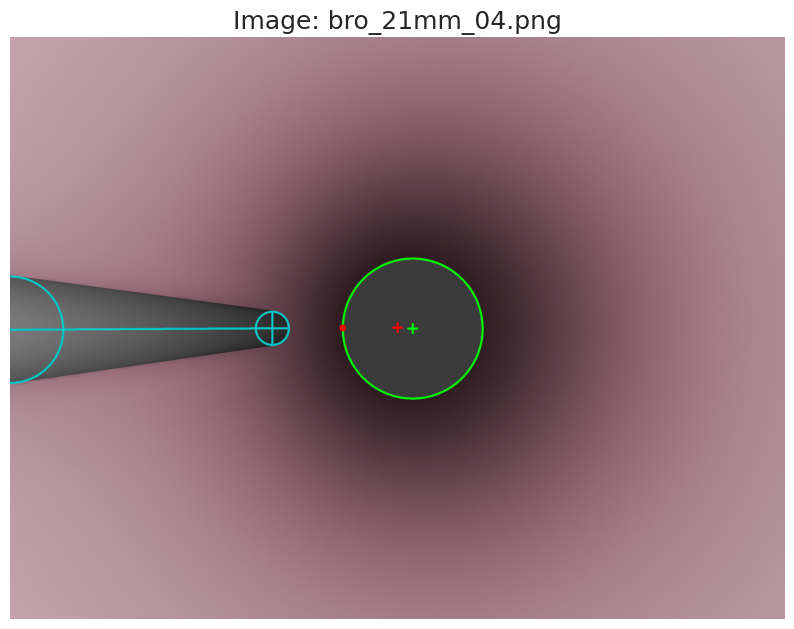

In [42]:
# show result of image 1. show everything on the image

def show_image_result(image_df, index=0):
    # dont use other predefined functions like draw_circle, draw_probe..
    # draw just from the row
    
    row = image_df.iloc[index]
    image = row['img'].copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    circle = row['circle']
    point_on_circle = row['point_on_circle']
    
    if circle is None: return
    
    if circle is not None:
        # draw circle from scratch
        cv2.circle(image, (circle[0], circle[1]), circle[2], (0, 255, 0), 8)
        # draw the center of the circle as cross
        size = 20
        cv2.line(image, (circle[0] - size, circle[1]), (circle[0] + size, circle[1]), (0, 255, 0), 8)
        cv2.line(image, (circle[0], circle[1] - size), (circle[0], circle[1] + size), (0, 255, 0), 8)
    # draw center of the image
    img_center = (image.shape[1] // 2, image.shape[0] // 2)
    cv2.line(image, (img_center[0] - size, img_center[1]), (img_center[0] + size, img_center[1]), (255, 0, 0), 8)
    cv2.line(image, (img_center[0], img_center[1] - size), (img_center[0], img_center[1] + size), (255, 0, 0), 8)
    # draw probe
    cv2.line(image, row['probe_base_center'], row['probe_tip_center'], (0, 200, 200), 8)
    # draw probe base
    cv2.ellipse(image, row['probe_base_center'], (row['probe_base_radius'], row['probe_base_radius']), 0, 0, 360, (0, 200, 200), 8)
    # draw probe tip
    cv2.line(image, (row['probe_tip_center'][0] - row['probe_tip_radius'], row['probe_tip_center'][1]), (row['probe_tip_center'][0] + row['probe_tip_radius'], row['probe_tip_center'][1]), (0, 200, 200), 8)
    cv2.line(image, (row['probe_tip_center'][0], row['probe_tip_center'][1] - row['probe_tip_radius']), (row['probe_tip_center'][0], row['probe_tip_center'][1] + row['probe_tip_radius']), (0, 200, 200), 8)
    cv2.ellipse(image, row['probe_tip_center'], (row['probe_tip_radius'], row['probe_tip_radius']), 0, 0, 360, (0, 200, 200), 8)
    # draw point on circle
    if point_on_circle is not None:
        cv2.circle(image, (int(point_on_circle[0]), int(point_on_circle[1])), 8, (255, 0, 0), 12)
    # draw predicted radius
    predicted_radius = row['predicted_radius']
    real_radius = row['real_radius']
    # cv2.putText(image, f'Predicted radius: {predicted_radius:.2f} mm', (20, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (20, 20, 20), 8)
    # cv2.putText(image, f'Real radius: {real_radius:.2f} mm', (20, 200), cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 255, 255), 8)
    # cv2.putText(image, f'Error: {row["error"]:.2f} mm', (10, 270), cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 50, 50), 8)
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.title(f'Image: {row["filename"]}')
    plt.axis('off')
    plt.show()

    
show_image_result(images_df, 13)

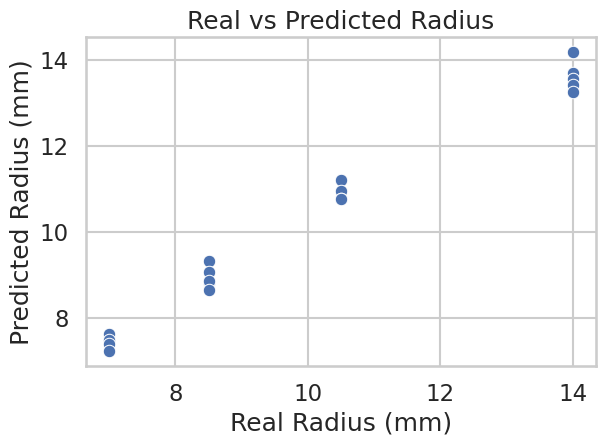

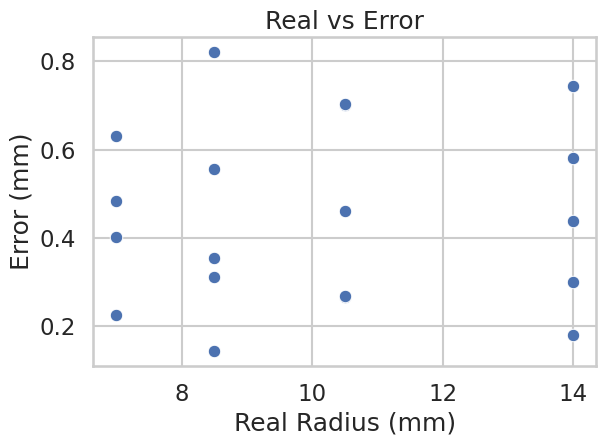

In [109]:
clean_df = images_df[images_df['circle'].notnull() & images_df['point_on_circle'].notnull() & images_df['predicted_radius'].notnull()]

# drop rows, where detected circe center is too far from the image center
clean_df['delta_size'] = clean_df['delta'].apply(lambda x: np.linalg.norm(x) if x is not None else None)
clean_df = clean_df[clean_df['delta_size'] < 500]

clean_df['circle_radius_px'] = clean_df['circle'].apply(lambda x: x[2] if x is not None else None)


# sns plot everything
sns.set(style="whitegrid")
sns.set_context("talk")
# plt.figure(figsize=(10, 10))
sns.scatterplot(x='real_radius', y='predicted_radius', data=clean_df)
plt.xlabel('Real Radius (mm)')
plt.ylabel('Predicted Radius (mm)')
plt.title('Real vs Predicted Radius')
plt.tight_layout()
plt.show()

sns.set(style="whitegrid")
sns.set_context("talk")
# plt.figure(figsize=(10, 10))
sns.scatterplot(x='real_radius', y='error', data=clean_df)
plt.xlabel('Real Radius (mm)')
plt.ylabel('Error (mm)')
plt.title('Real vs Error')
plt.tight_layout()
plt.show()



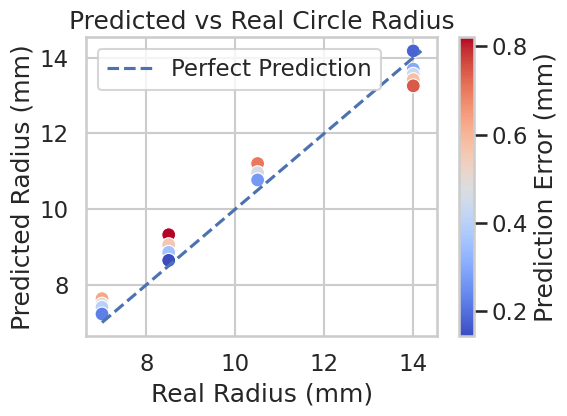

In [110]:
clean_df['distance'] = clean_df['filename'].apply(lambda x: int(x.split('_')[2].split('.')[0]))

plt.figure(figsize=(6, 4.5))
ax = sns.scatterplot(
    x='real_radius', 
    y='predicted_radius', 
    data=clean_df, 
    s=100, 
    hue='error', 
    palette='coolwarm',  # Blue (low error) to red (high error)
    legend=''  # Suppress default legend, as we'll use a colorbar
)

# Add the perfect prediction line
min_val = min(clean_df['real_radius'].min(), clean_df['predicted_radius'].min())
max_val = max(clean_df['real_radius'].max(), clean_df['predicted_radius'].max())
ax.plot([min_val, max_val], [min_val, max_val], 'b--', label='Perfect Prediction')

# Create a colorbar tied to the error values
norm = plt.Normalize(clean_df['error'].min(), clean_df['error'].max())
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])
cbar = ax.figure.colorbar(sm, ax=ax, label='Prediction Error (mm)')

# Add labels and title with color explanation
plt.xlabel('Real Radius (mm)')
plt.ylabel('Predicted Radius (mm)')
plt.title('Predicted vs Real Circle Radius')
plt.legend()
plt.tight_layout()
plt.savefig('data/output/plot/predicted_vs_real_radius.pdf')
plt.show()



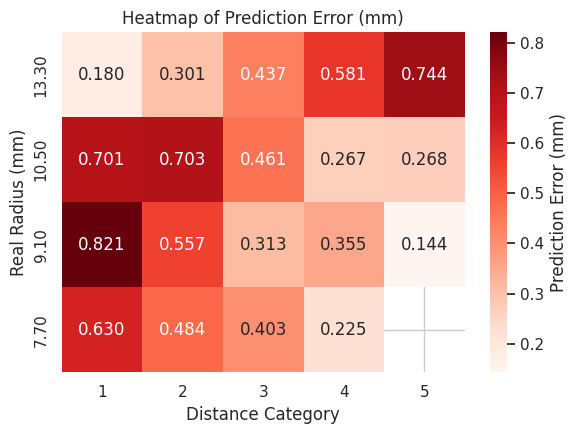

In [111]:
tdf = pd.DataFrame(clean_df[['filename', 'real_radius', 'height_at_circle', 'error']].copy())
tdf['distance'] = tdf['filename'].apply(lambda x: int(x.split('_')[2].split('.')[0]))

# Bin real_radius (continuous) into 5 bins
tdf['real_radius_bin'] = pd.cut(tdf['real_radius'], bins=5, labels=False, include_lowest=True)

# Create pivot table with mean error, using raw distance values (1, 2, 3, 4, 5) as columns
pivot_table = tdf.pivot_table(values='error', index='real_radius_bin', columns='distance', aggfunc='mean')

# Reorder pivot_table rows in descending order (higher real_radius_bin at the top)
pivot_table = pivot_table.sort_index(ascending=False)

# Map real_radius_bin indices to approximate midpoints for readability
real_radius_categories = pd.cut(tdf['real_radius'], bins=5, include_lowest=True).cat.categories
# Align midpoints with reordered indices
pivot_table.index = [f'{real_radius_categories[int(idx)].mid:.2f}' for idx in pivot_table.index]

# Distance columns are already 1, 2, 3, 4, 5 (no binning needed), convert to strings
pivot_table.columns = [f'{int(col)}' for col in pivot_table.columns]

# Set Seaborn style
sns.set_theme(style="whitegrid")

# Create the heatmap
plt.figure(figsize=(6, 4.5))
sns.heatmap(
    pivot_table,
    cmap='Reds',  # Red gradient for error magnitude
    annot=True,   # Show error values in cells
    fmt='.3f',    # Format numbers to 3 decimal places
    cbar_kws={'label': 'Prediction Error (mm)'},  # Colorbar label
    vmin=tdf['error'].min(),  # Set color scale minimum
    vmax=tdf['error'].max()   # Set color scale maximum
)

# Add labels and title
plt.xlabel('Distance Category')
plt.ylabel('Real Radius (mm)')
plt.title('Heatmap of Prediction Error (mm)')
plt.tight_layout()
plt.savefig('data/output/plot/heatmap_prediction_error.pdf')
plt.show()

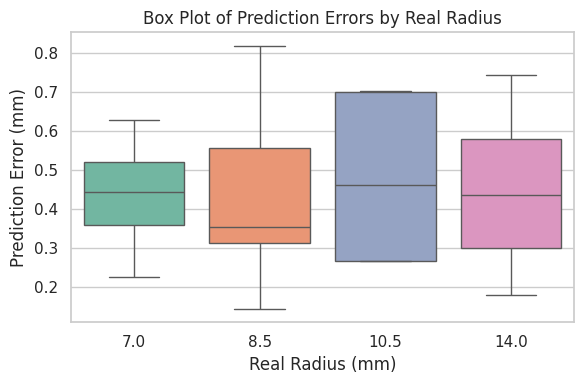

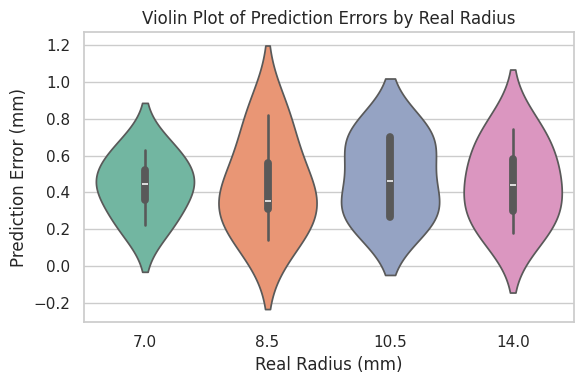

In [54]:
# Create Box and Whiskers Plot
plt.figure(figsize=(6, 4))
sns.boxplot(
    x='real_radius',
    y='error',
    data=clean_df,
    hue='real_radius',
    palette='Set2',  # Distinct colors for each real_radius
    legend=False  # Suppress legend since x-axis labels suffice
)
plt.xlabel('Real Radius (mm)')
plt.ylabel('Prediction Error (mm)')
plt.title('Box Plot of Prediction Errors by Real Radius')
plt.tight_layout()
plt.savefig('data/output/plot/box_plot_prediction_error.pdf')
plt.show()

# Create Violin Plot
plt.figure(figsize=(6, 4))
sns.violinplot(
    x='real_radius',
    y='error',
    data=clean_df,
    hue='real_radius',
    palette='Set2',
    legend=False
)
plt.xlabel('Real Radius (mm)')
plt.ylabel('Prediction Error (mm)')
plt.title('Violin Plot of Prediction Errors by Real Radius')
plt.tight_layout()
plt.show()

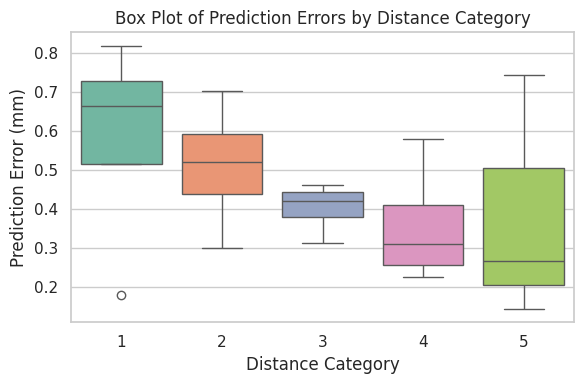

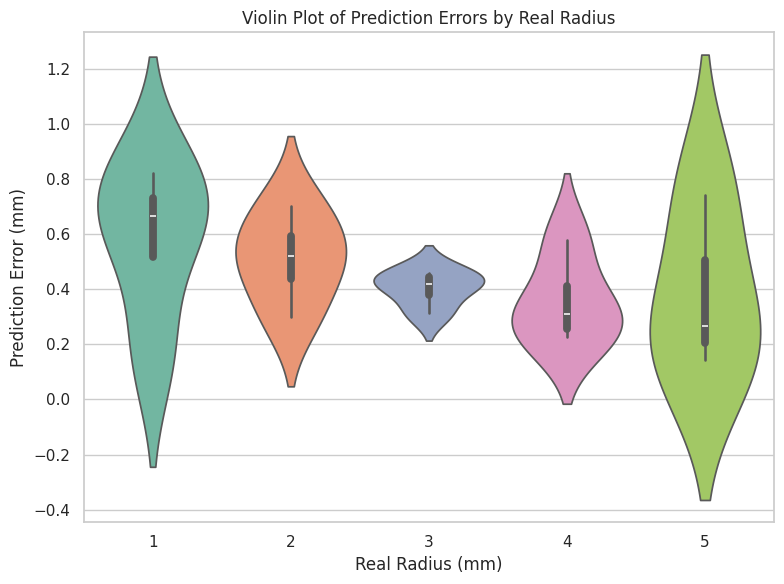

In [53]:
plt.figure(figsize=(6, 4))
sns.boxplot(
    x='distance',
    y='error',
    data=clean_df,
    hue='distance',
    palette='Set2',  # Distinct colors for each real_radius
    legend=False  # Suppress legend since x-axis labels suffice
)
plt.xlabel('Distance Category')
plt.ylabel('Prediction Error (mm)')
plt.title('Box Plot of Prediction Errors by Distance Category')
plt.tight_layout()
plt.savefig('data/output/plot/box_plot_prediction_error_by_distance.pdf')
plt.show()

# Create Violin Plot
plt.figure(figsize=(8, 6))
sns.violinplot(
    x='distance',
    y='error',
    data=clean_df,
    hue='distance',
    palette='Set2',
    legend=False
)
plt.xlabel('Real Radius (mm)')
plt.ylabel('Prediction Error (mm)')
plt.title('Violin Plot of Prediction Errors by Real Radius')
plt.tight_layout()
plt.show()

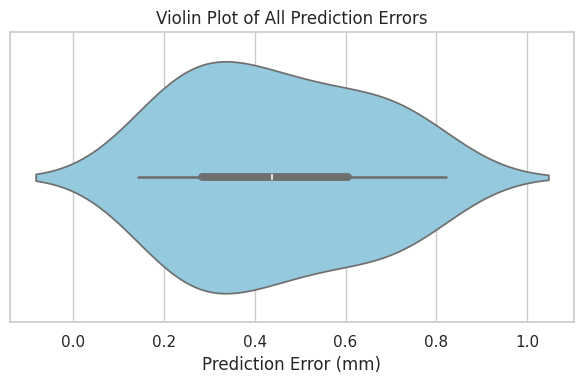

In [60]:
# Create Violin Plot
plt.figure(figsize=(6, 4))
sns.violinplot(
    x='error',
    data=clean_df,
    color='skyblue',  # Single color for the violin
    inner='box'  # Show quartiles and median inside the violin,
)
plt.xlabel('Prediction Error (mm)')
plt.title('Violin Plot of All Prediction Errors')
plt.tight_layout()
# plt.savefig('data/output/plot/violin_plot_all_prediction_errors.pdf')
plt.show()

In [61]:
clean_df['error'].describe()

count    19.000000
mean      0.451186
std       0.204008
min       0.143502
25%       0.284643
50%       0.437476
75%       0.605229
max       0.820512
Name: error, dtype: float64

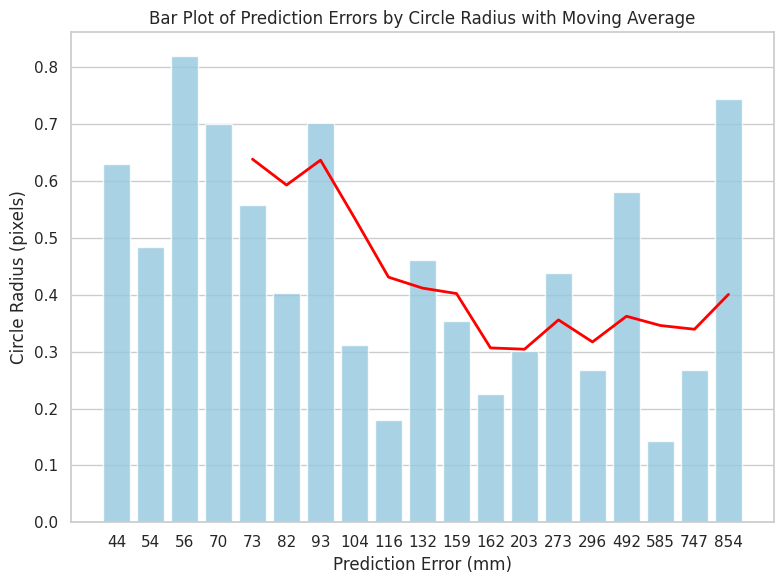

In [112]:
# Aggregate mean error by circle_radius_px for the bar plot
agg_df = clean_df.groupby('circle_radius_px')['error'].mean().reset_index()

# Sort by circle_radius_px for numerical order
agg_df = agg_df.sort_values('circle_radius_px')

# Calculate moving average (window size = 3)
window_size = 5
agg_df['moving_avg'] = agg_df['error'].rolling(window=window_size, center=False).mean()

# Set Seaborn style
sns.set_theme(style="whitegrid")

# Create Horizontal Bar Plot with Moving Average
plt.figure(figsize=(8, 6))
# Bar plot
ax = sns.barplot(
    x='circle_radius_px',  # Mean error on x-axis
    y='error',
    data=agg_df,
    color='skyblue',  # Skyblue bars
    alpha=0.8  # Slight transparency for visibility of line
)

# Overlay moving average line
# ax2 = ax.twinx()  # Secondary y-axis for moving average


ax.plot(
    # agg_df['circle_radius_px'],
    agg_df['moving_avg'],
    color='red',  # Red line for contrast
    linewidth=2,
    label='Moving Average (window=3)'
)

# sns.lineplot(
#     x=agg_df['circle_radius_px'],
#     y=agg_df['moving_avg'],
#     ax=ax2,
#     color='red',  # Red line for contrast
#     linewidth=2,
#     # marker='Moving Average (window=3)'
# )

# Customize axes
ax.set_xlabel('Prediction Error (mm)')
ax.set_ylabel('Circle Radius (pixels)')
ax2.set_ylabel('Moving Average Error (mm)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
plt.title('Bar Plot of Prediction Errors by Circle Radius with Moving Average')
plt.tight_layout()

# Display plot
plt.show()

## Undistort

In [49]:
for i in images:
    image = i[1].copy()
    focal_length_mm = 40.0  # in millimeters (example)
    sensor_width_mm = 60.4  # in millimeters (example)
    sensor_height_mm = 40.8  # in millimeters (example)

    # Assume an image resolution (for example, 640x480)
    image_width, image_height, _ = image.shape

    # Compute pixel size (in mm/pixel)
    pixel_size_x = sensor_width_mm / image_width
    pixel_size_y = sensor_height_mm / image_height

    # Convert focal length to pixels
    focal_length_px = focal_length_mm / pixel_size_x  # you can use either dimension if pixels are square

    # Construct the intrinsic camera matrix
    CAMERA_MATRIX = np.array([[focal_length_px, 0, image_width/2],
                            [0, focal_length_px, image_height/2],
                            [0, 0, 1]], dtype=np.float32)

    # Example distortion coefficients
    # If you don't have these values, you might start with zeros, but calibration is recommended
    DIST_COEFFS = np.ones((4, 1))  # assuming minimal distortion

    undistorted_image = cv2.undistort(image, CAMERA_MATRIX, DIST_COEFFS)

    # overlay B channel of the undistorted image on the R and G channels of the original image
    overlay = cv2.merge((undistorted_image[:, :, 0], image[:, :, 1], image[:, :, 2]))

    # draw the 3 images
    plt.figure(figsize=(10, 10))
    plt.subplot(131)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Original Image')
    plt.subplot(132)
    plt.imshow(undistorted_image)
    plt.axis('off')
    plt.title('Undistorted Image')
    plt.subplot(133)
    plt.imshow(overlay)
    plt.axis('off')
    plt.title('Overlay')
    plt.show()



NameError: name 'images' is not defined

In [ ]:
image.shape

(2464, 3280, 3)

## Experiments

In [ ]:
# using cv2 find a gray circle the middle of the image

def find_circle(image):
    """
    Find a circle in the middle of the image.

    Parameters:
    image (np.array): The image to search for a circle.

    Returns:
    tuple: A tuple containing the x, y coordinates and the radius of the circle.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = cv2.medianBlur(gray, 5)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=0, maxRadius=0)
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            return (i[0], i[1], i[2])
    return None



# paint the circle on the image
def draw_circle(image, circle, size=20, width=5, color=(0, 0, 255)):
    """
    Draw a circle on the image.

    Parameters:
    image (np.array): The image to draw the circle on.
    circle (tuple): A tuple containing the x, y coordinates and the radius of the circle.

    Returns:
    np.array: The image with the circle drawn on it.
    """
    if circle is not None:
        cv2.circle(image, (circle[0], circle[1]), circle[2], (0, 255, 0), 1)
        # draw the center of the circle as cross
        cv2.line(image, (circle[0] -size, circle[1]), (circle[0] +size, circle[1]), (0, 255, 0), width)
        cv2.line(image, (circle[0], circle[1] -size), (circle[0], circle[1] +size), (0, 255, 0), width)
        
    return image


def draw_center(image, size=20, width=5, color=(0, 0, 255)):
    """
    Draw the center of the image on the image.

    Parameters:
    image (np.array): The image to draw the center on.

    Returns:
    np.array: The image with the center drawn on it.
    """
    img_center = (image.shape[1] // 2, image.shape[0] // 2)
    cv2.line(image, (img_center[0] - size, img_center[1]), (img_center[0] + size, img_center[1]), color, width)
    cv2.line(image, (img_center[0], img_center[1] - size), (img_center[0], img_center[1] + size), color, width)
    return image

def plt_img(image, title=None):
    scale2x = cv2.resize(image, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

In [ ]:
import pandas as pd

probe_tip_data = pd.DataFrame(columns=['probe_length', 'probe_tip_center_x', 'probe_tip_center_y', 'probe_tip_radius'])

data_to_append = [
    {
        'probe_length': 0.02028 + 0.015, # = 0.03528 
        'probe_tip_center_x': 1308, 
        'probe_tip_center_y': 1233, 
        'probe_tip_radius': 45
    },
    {
        'probe_length': 0.02028 + 0.010, # = 0.03028
        'probe_tip_center_x': 1261, 
        'probe_tip_center_y': 1233, 
        'probe_tip_radius': 51
    },
    {
        'probe_length': 0.02028 + 0.005, # = 0.02528
        'probe_tip_center_x': 1193, 
        'probe_tip_center_y': 1234, 
        'probe_tip_radius': 62
    },
    {
        'probe_length': 0.02028, 
        'probe_tip_center_x': 1110, 
        'probe_tip_center_y': 1235, 
        'probe_tip_radius': 70
    },
    {
        'probe_length': 0.02028 - 0.005, # = 0.01528
        'probe_tip_center_x': 971, 
        'probe_tip_center_y': 1235, 
        'probe_tip_radius': 92
    },
    {
        'probe_length': 0.02028 - 0.010, # = 0.01028
        'probe_tip_center_x': 749, 
        'probe_tip_center_y': 1236, 
        'probe_tip_radius': 123
    },
    {
        'probe_length': 0.02028 - 0.015, # = 0.00528
        'probe_tip_center_x': 290, 
        'probe_tip_center_y': 1237, 
        'probe_tip_radius': 184
    },
    {
        'probe_length': 0.02028 - 0.016, # = 0.00428
        'probe_tip_center_x': 128, 
        'probe_tip_center_y': 1239, 
        'probe_tip_radius': 207
    }
]

probe_tip_data = pd.concat([probe_tip_data, pd.DataFrame(data_to_append)], ignore_index=True)
probe_tip_data['probe_tip_left_x'] = probe_tip_data['probe_tip_center_x'] - probe_tip_data['probe_tip_radius']

/tmp/ipykernel_579672/1936683359.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  probe_tip_data = pd.concat([probe_tip_data, pd.DataFrame(data_to_append)], ignore_index=True)


In [ ]:
t_images = load_images(os.path.join(DATA_PATH, 'probe_test'))
for i, x in enumerate(t_images):
    print(i, x[0])

0 f
1 i
2 r


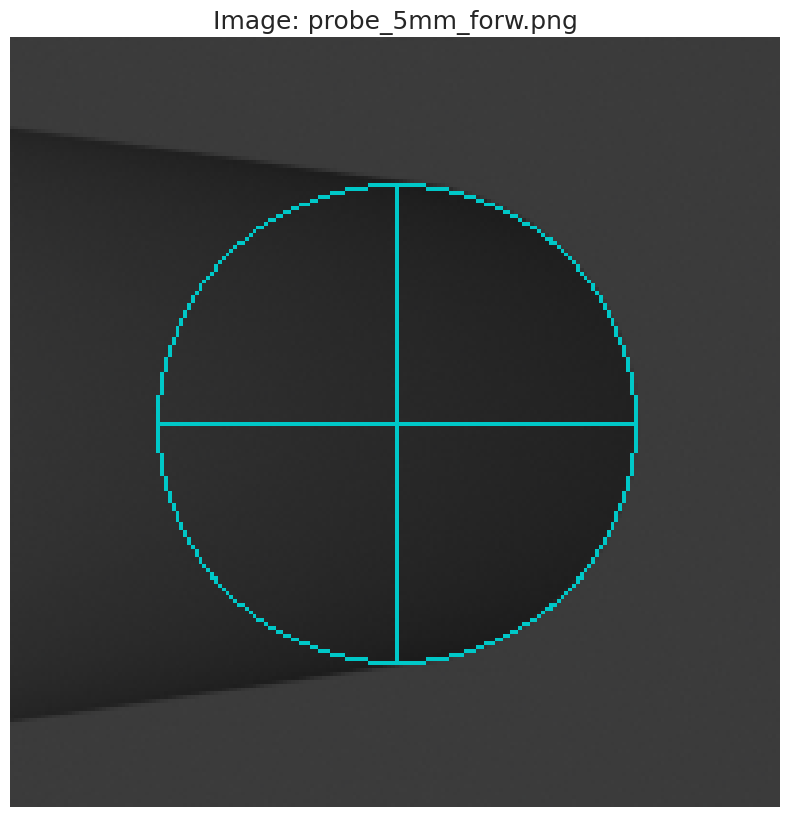

In [ ]:
i = 7
image = t_images.iloc[i]['img'].copy()
image_title = f"Image: {t_images.iloc[i]['filename']}"


probe_length = 0.02028 - 0.010  # The length of the probe in meters
probe_width = 0.002  # The width of the probe in meters
probe_offset_x = 0.00221
probe_offset_y = 0

focal_length = 0.00275  # The focal length of the camera in mm
sensor_width = 0.00645  # The width of the camera sensor in mm
sensor_height = 0.00363  # The height of the camera sensor in mm


probe_base_center = (0, 1241)
probe_base_radius = 225


probe_tip_center = (1110, 1237)
probe_tip_radius = 184
probe_tip_left = (probe_tip_center[0] - 184, probe_tip_center[1])

data =     {
        'probe_length': 0.02028 + 0.005, 
        'probe_tip_center_x': 1189, 
        'probe_tip_center_y': 1234, 
        'probe_tip_radius': 62
    }

probe_length = data['probe_length']
probe_tip_center = (data['probe_tip_center_x'], data['probe_tip_center_y'])
probe_tip_radius = data['probe_tip_radius']

crop_factor = 100

def draw_probe(image, size=70, width=1, color=(0, 200, 200)):
    """
    Draw the center of the image on the image.

    Parameters:
    image (np.array): The image to draw the center on.

    Returns:
    np.array: The image with the center drawn on it.
    """
    # draw the probe base
    # cv2.line(image, probe_base_center, probe_tip_center, color, width)

    # cv2.ellipse(image, probe_base_center, (int(probe_base_radius*(1)), probe_base_radius), 0, 0, 360, color, width*5)
    def _():
        # probe_base_radius = int(probe_base_radius * 0.72)
        for i in range(11):
            mult = i * 0.1
            height = int(probe_tip_radius*mult + probe_base_radius * (1-mult))
            mult_w = mult
            width = int(probe_tip_radius*mult_w + probe_base_radius * (1-mult_w))
            center = (int(probe_tip_center[0] * mult), probe_tip_center[1])
            cv2.ellipse(image, center, (width, height), 0, 0, 360, color, 1)
    # _()
    
    # cv2.line(image, probe_tip_left, (circle_left - delta_y), (200,20,150), width*2)

    # draw cross for the probe tip
    cv2.line(image, (probe_tip_center[0] - probe_tip_radius, probe_tip_center[1]), (probe_tip_center[0] + probe_tip_radius, probe_tip_center[1]), color, width)
    cv2.line(image, (probe_tip_center[0], probe_tip_center[1] - probe_tip_radius), (probe_tip_center[0], probe_tip_center[1] + probe_tip_radius), color, width)
    cv2.ellipse(image, probe_tip_center, (probe_tip_radius, probe_tip_radius), 0, 0, 360, color, width)
    
    # crop middle 200x200
    x1 = max(probe_tip_center[0] - crop_factor, 0)
    y1 = max(probe_tip_center[1] - crop_factor, 0)
    x2 = min(probe_tip_center[0] + crop_factor, image.shape[1])
    y2 = min(probe_tip_center[1] + crop_factor, image.shape[0])
    image = image[y1:y2, x1:x2]
    
    
    
    plt_img(image, image_title)


draw_probe(image.copy())



In [ ]:
probe_tip_data

(1308, 1233)

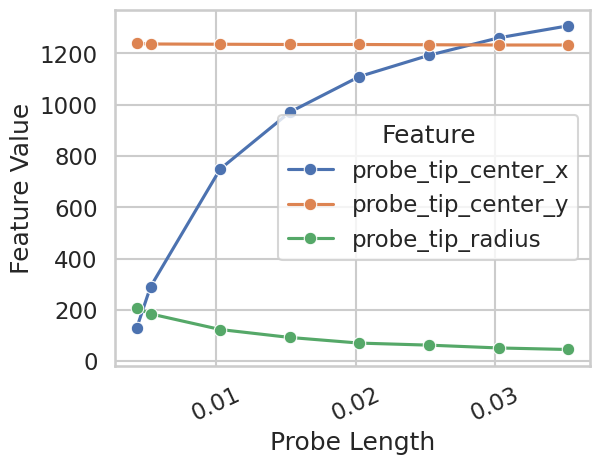

In [ ]:

df_long = probe_tip_data.melt(id_vars='probe_length', 
                              value_vars=[col for col in probe_tip_data.columns if col not in ['probe_length', 'probe_tip_left_x']],
                              var_name='Feature', value_name='Value')

# Plot all features against probe_length with separate lines
sns.lineplot(data=df_long, x='probe_length', y='Value', hue='Feature', marker='o')
# plt.title('Probe Features vs Probe Length')
plt.xlabel('Probe Length')
plt.ylabel('Feature Value')
plt.legend(title='Feature')
plt.tight_layout()
plt.xticks(rotation=25)
plt.savefig('data/output/plot/probe_length_vs_features.pdf')
plt.show()

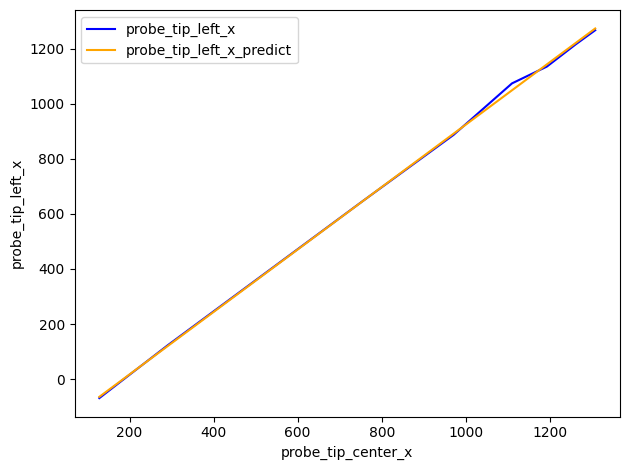

In [ ]:
probe_tip_data['probe_tip_left_x'] = probe_tip_data['probe_tip_center_x'] - probe_tip_data['probe_tip_width']
s = lambda x: probe_center_x_to_tip_width(x)
probe_tip_data['probe_tip_left_x_predict'] = probe_tip_data['probe_tip_center_x'] - s(probe_tip_data['probe_tip_center_x'])


# line plot all the other attrs against the probe length (probe length is the x axis)
# plt.figure(figsize=(10, 10))
# sns.lineplot(x='probe_length', y='probe_tip_center_x', data=probe_tip_data, color='red', label="probe_tip_center_x")
sns.lineplot(x='probe_tip_center_x', y='probe_tip_left_x', data=probe_tip_data, color='blue', label="probe_tip_left_x")
sns.lineplot(x='probe_tip_center_x', y='probe_tip_left_x_predict', data=probe_tip_data, color='orange', label="probe_tip_left_x_predict")
plt.tight_layout()
plt.legend()
plt.show()


linear: [-1.20690106e-01  1.97422762e+02]


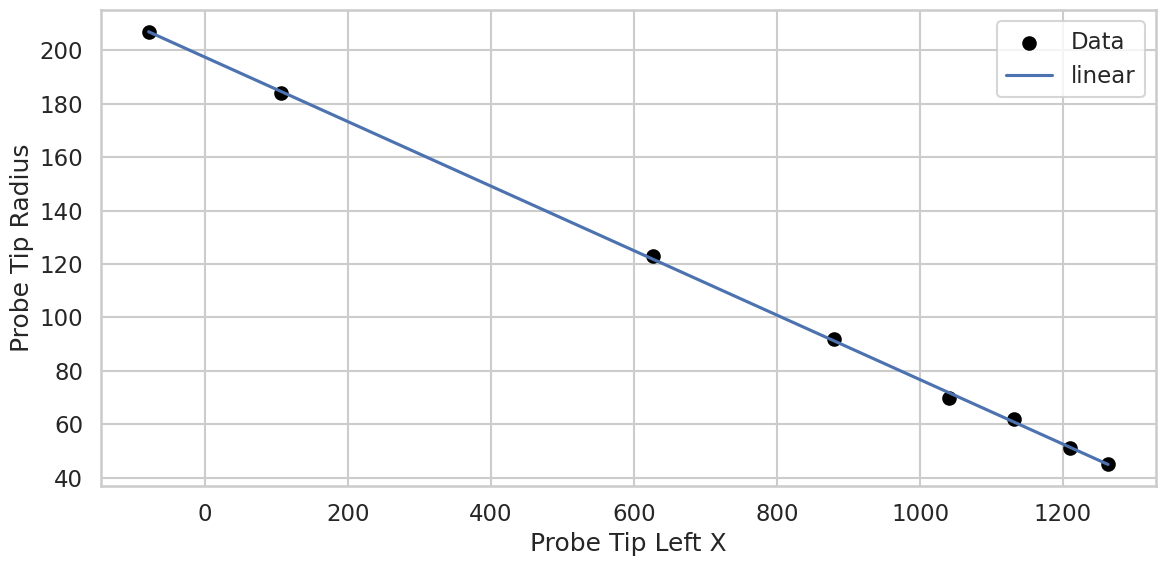

In [ ]:
from scipy.optimize import curve_fit
from scipy.special import expit
import numpy as np
import matplotlib.pyplot as plt

# Define functions
def linear(x, a, b):
    return a * x + b

def quadratic(x, a, b, c):
    return a * x**2 + b * x + c

def cubic(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

def exponential(x, a, b, c):
    return a * np.exp(b * x) + c

def logarithmic(x, a, b, c, d):
    return a * np.log(x * c + d) + b

def sigmoid(x, a, b, c):
    return a * expit(b * (x - c))
def gaussian(x, a, b, c):
    return a * np.exp(-0.5 * ((x - c) / b)**2)

fit_funcs = {
    'linear': (linear, None),
    # 'quadratic': (quadratic, None),
    # 'cubic': (cubic, None),
    # 'exponential': (exponential, [1, 0.001, 1]),
    # 'logarithmic': (logarithmic, [1, 1, 0.01, 1]),
    # 'sigmoid': (sigmoid, [1, 1, np.mean(x)]),
    # 'gaussian': (gaussian, [1, 1, np.mean(x)])
}

# Data
x = probe_tip_data['probe_tip_left_x'].astype(float).to_numpy()
y = probe_tip_data['probe_tip_radius'].astype(float).to_numpy()

# Sort x and y for smoother lines
sort_idx = np.argsort(x)
x_sorted = x[sort_idx]
y_sorted = y[sort_idx]

plt.figure(figsize=(12, 6))
plt.scatter(x, y, color='black', label='Data')

# Fit and plot each function
for name, (func, p0) in fit_funcs.items():
    try:
        popt, _ = curve_fit(func, x, y, p0=p0, maxfev=5000)
        y_fit = func(x_sorted, *popt)
        plt.plot(x_sorted, y_fit, label=name)
        print(f"{name}: {popt}")
    except Exception as e:
        print(f"{name} fitting failed: {e}")

# plt.title('Curve Fits for Probe Length vs Probe Tip X')
plt.xlabel('Probe Tip Left X')
plt.ylabel('Probe Tip Radius')
plt.legend()
plt.tight_layout()
plt.savefig('data/output/plot/curve_fits_probe_tip_left_x_to_radius.pdf')
plt.show()


def probe_tip_left_x_to_height(x):
    a, b = [-1.28672515e-01,  2.11080355e+02]
    return a * x + b

In [ ]:
xpx_to_probe_distance(x[3])

array(0.019786)

0.03528 0.005446569353785335
0.03028 0.005446564398700503
0.02528 0.005446559443704153
0.02028 0.005446554488796284
0.015279999999999998 0.005446549533976895
0.01028 0.005446544579245984
0.00528 0.00544653962460355
0.004279999999999999 0.00544653863368568


/tmp/ipykernel_115555/1168990564.py:8: RuntimeWarning: invalid value encountered in log
  return np.log(57960*x-299.6) + 800


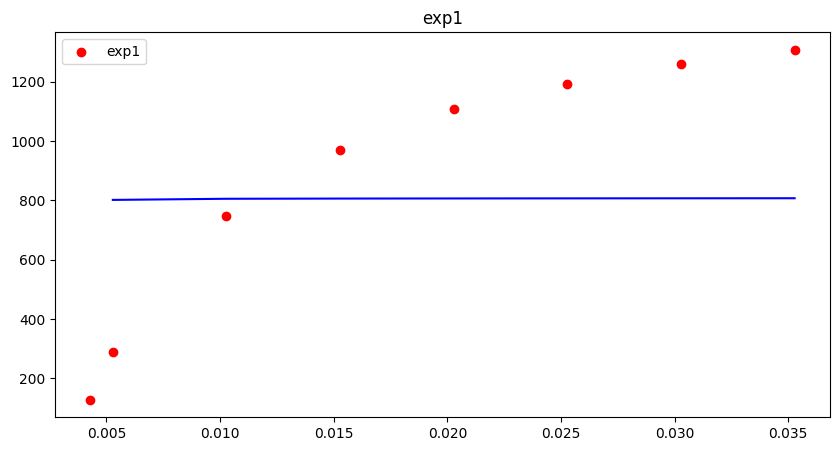

In [ ]:
def xpx_to_probe_distance(x):
    def fn(x):
        return (np.exp((-800+x)/280)+1.07)/207
    return np.vectorize(fn)(x)

def probe_distance_to_xpx(x):
    def fn(x):
        return np.log(57960*x-299.6) + 800
    return np.vectorize(fn)(x)


# plot the function along the data
x = probe_tip_data['probe_length'].to_numpy()
y = probe_tip_data['probe_tip_center_x'].to_numpy()

for a in x:
    print(a, xpx_to_probe_distance(a))

plt.figure(figsize=(10, 5))
plt.scatter(x, y, color='red')
plt.plot(x, probe_distance_to_xpx(x), color='blue')
plt.title('exp1')
plt.legend(['exp1'])
plt.show()


In [ ]:
dummy_probe_lengths = np.linspace(0.000, 0.01, 100000)
d_df = pd.DataFrame({'probe_length': dummy_probe_lengths})
d_df['probe_tip_center_x'] = [float(probe_distance_to_xpx(x)) for x in dummy_probe_lengths]

# delete rows where probe_tip_center_x is nan
d_df = d_df.dropna(subset=['probe_tip_center_x'])

/tmp/ipykernel_579672/2580367981.py:215: RuntimeWarning: invalid value encountered in log
  return 800 - 280*np.log(207*d - 1.07)


In [ ]:
d_df

,probe_length,probe_tip_center_x
51691,0.005169,794.486517
51692,0.005169,795.377490
51693,0.005169,795.841063
51694,0.005169,796.156580
51695,0.005170,796.396060
...,...,...
99995,0.010000,805.634707
99996,0.010000,805.634728
99997,0.010000,805.634748
99998,0.010000,805.634769


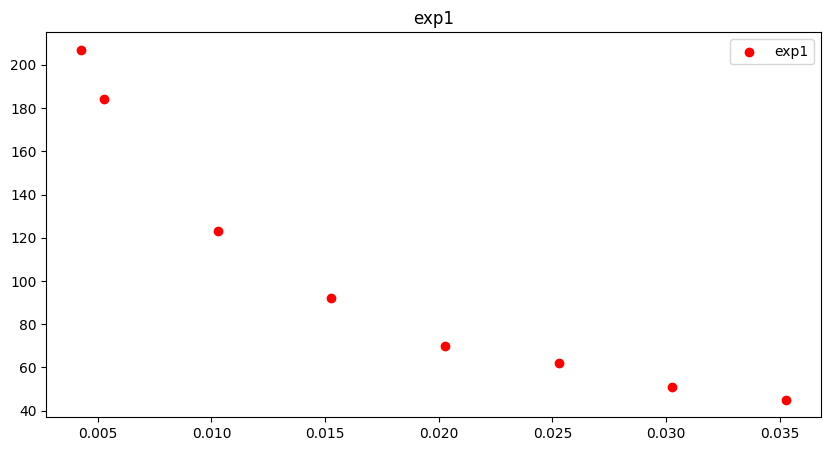

In [ ]:
# plot the function along the data
x = probe_tip_data['probe_length'].to_numpy()
y = probe_tip_data['probe_tip_radius'].to_numpy()

plt.figure(figsize=(10, 5))
plt.scatter(x, y, color='red')
plt.title('exp1')
plt.legend(['exp1'])
plt.show()

## 3d render

Pixel coordinate of the back-face center: [311.30679499 180.        ]


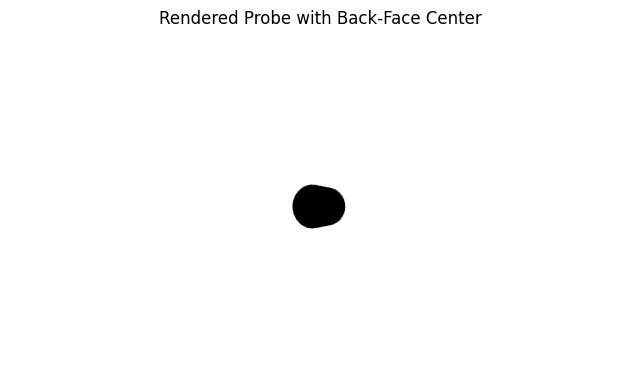

In [ ]:
import numpy as np
import trimesh
import pyrender
import matplotlib.pyplot as plt

# -------------------------------
# Helper: Look-at view matrix
# -------------------------------
def look_at(eye, target, up):
    forward = target - eye
    forward /= np.linalg.norm(forward)
    right = np.cross(forward, up)
    right /= np.linalg.norm(right)
    true_up = np.cross(right, forward)
    
    view = np.eye(4)
    view[0, :3] = right
    view[1, :3] = true_up
    view[2, :3] = -forward
    view[:3, 3] = -np.dot(view[:3, :3], eye)
    return view

# -------------------------------
# Parameters for the probe (in meters)
# -------------------------------
probe_length = 0.02028   # 0.03528 m
probe_width  = 0.002            # probe full width = 2 mm, so radius will be half of that
probe_width  = 0.02            # probe full width = 2 mm, so radius will be half of that

probe_offset_x = 0.00221
probe_offset_x = 0.221
probe_offset_y = 0.05

# -------------------------------
# Camera parameters (in meters)
# -------------------------------
focal_length = 0.00275         # 2.75 mm focal length
sensor_width = 0.00645         # 6.45 mm sensor width
sensor_height = 0.00363        # 3.63 mm sensor height

# Compute vertical field-of-view from sensor height and focal length:
yfov = 2 * np.arctan(sensor_height / (2 * focal_length))
# Aspect ratio from sensor dimensions:
aspect_ratio = sensor_width / sensor_height

# We'll choose an image resolution that matches the sensor aspect ratio.
img_width = 640
img_height = int(img_width / aspect_ratio)  # e.g. 640 x 360 for 16:9

# -------------------------------
# Define camera position relative to the probe.
# For a small probe, we place the camera fairly close.
# We want the probe to appear roughly centered in the image.
# We'll set the camera's eye to be along the positive x-axis,
# and have it look at the probe center (which is at the probe offset).
# -------------------------------
cam_eye = np.array([0.1, 0.0, 0.0])  # 10 cm away along x-axis
probe_center = np.array([probe_offset_x, probe_offset_y, 0.0])
cam_target = probe_center
cam_up = np.array([0.0, 0.0, 1.0])
view_matrix = look_at(cam_eye, cam_target, cam_up)

# -------------------------------
# Create the pyrender camera using the computed vertical FOV.
# -------------------------------
camera = pyrender.PerspectiveCamera(
    yfov=yfov,
    aspectRatio=aspect_ratio,
    znear=0.001,
    zfar=1.0
)
# The camera node’s pose is the inverse of the view matrix.
cam_pose = np.linalg.inv(view_matrix)

# -------------------------------
# Create the scene and add the camera.
# -------------------------------
scene = pyrender.Scene()
scene.add(camera, pose=cam_pose)

# -------------------------------
# Create the probe as a cylinder.
# -------------------------------
# Note: trimesh creates a cylinder along the z-axis (faces at z = ±height/2).
# For the probe, use:
radius = probe_width / 2.0
height_cyl = probe_length

# Create cylinder with specified dimensions.
probe_mesh = trimesh.creation.cylinder(radius=radius, height=height_cyl, sections=32)
# Rotate by +90° about the y-axis so that the long axis points along +x.
R = trimesh.transformations.rotation_matrix(np.deg2rad(90), [0, 1, 0])
probe_mesh.apply_transform(R)

# Translate the probe by the given offsets.
T = np.eye(4)
T[:3, 3] = [probe_offset_x, probe_offset_y, 0.0]
probe_mesh.apply_transform(T)

# Add the probe to the scene with flat shading.
probe_pyrender = pyrender.Mesh.from_trimesh(probe_mesh, smooth=True)
scene.add(probe_pyrender)

# -------------------------------
# Compute the back-face center.
# -------------------------------
# Since the original cylinder is along z (with faces at ±height/2) and we rotated by 90° about y,
# the face originally at z = -height/2 becomes the back face.
back_face_local = np.array([0, 0, -height_cyl/2.0, 1.0])
# The overall transform is T @ R.
back_face_world = (T @ R) @ back_face_local

# -------------------------------
# Render the scene.
# -------------------------------
renderer = pyrender.OffscreenRenderer(viewport_width=img_width, viewport_height=img_height)
color, depth = renderer.render(scene)
renderer.delete()

# -------------------------------
# Get the camera's projection matrix.
# -------------------------------
proj_matrix = camera.get_projection_matrix(img_width, img_height)

# -------------------------------
# Function to project world point to pixel coordinates.
# -------------------------------
def world_to_pixel(world_pt, view, proj, img_w, img_h):
    p = np.append(world_pt, 1.0)
    clip = proj @ (view @ p)
    ndc = clip[:3] / clip[3]
    x = (ndc[0] + 1) * 0.5 * img_w
    y = (1 - ndc[1]) * 0.5 * img_h  # y=0 at top
    return np.array([x, y])

pixel_coord = world_to_pixel(back_face_world[:3], view_matrix, proj_matrix, img_width, img_height)

# -------------------------------
# Plot the rendered image and overlay the red cross.
# -------------------------------
plt.figure(figsize=(8, 6))
plt.imshow(color)
plt.title("Rendered Probe with Back-Face Center")
plt.axis("off")

# Draw a red cross at the computed pixel coordinate.
# x, y = pixel_coord
# plt.plot([x - 5, x + 5], [y, y], color='red', linewidth=2)
# plt.plot([x, x], [y - 5, y + 5], color='red', linewidth=2)
# plt.show()

print("Pixel coordinate of the back-face center:", pixel_coord)
